In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Transformasi dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Load dataset SVHN
trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 182M/182M [00:54<00:00, 3.31MB/s]
100%|██████████| 64.3M/64.3M [00:02<00:00, 24.0MB/s]


In [4]:
# Definisi Model CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

In [5]:
# Inisialisasi Model
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training Loop
num_epochs = 10
train_acc_list, test_acc_list = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = correct / total
    train_acc_list.append(train_acc)

    # Evaluasi Model
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    test_acc = correct / total
    test_acc_list.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1/10, Loss: 2.0673, Train Acc: 0.3932, Test Acc: 0.5086
Epoch 2/10, Loss: 1.9530, Train Acc: 0.5079, Test Acc: 0.5104
Epoch 3/10, Loss: 1.9459, Train Acc: 0.5135, Test Acc: 0.5205
Epoch 4/10, Loss: 1.9418, Train Acc: 0.5169, Test Acc: 0.5212
Epoch 5/10, Loss: 1.9207, Train Acc: 0.5384, Test Acc: 0.5738
Epoch 6/10, Loss: 1.8400, Train Acc: 0.6205, Test Acc: 0.6388
Epoch 7/10, Loss: 1.8114, Train Acc: 0.6487, Test Acc: 0.6315
Epoch 8/10, Loss: 1.8039, Train Acc: 0.6558, Test Acc: 0.6490
Epoch 9/10, Loss: 1.7999, Train Acc: 0.6596, Test Acc: 0.6494
Epoch 10/10, Loss: 1.7955, Train Acc: 0.6637, Test Acc: 0.6755


In [7]:
# Evaluasi Akhir
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'CNN Test Accuracy: {accuracy:.4f}')
print(f'CNN Precision: {precision:.4f}')
print(f'CNN Recall: {recall:.4f}')
print(f'CNN F1 Score: {f1:.4f}')

CNN Test Accuracy: 0.6755
CNN Precision: 0.4841
CNN Recall: 0.5951
CNN F1 Score: 0.5227


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


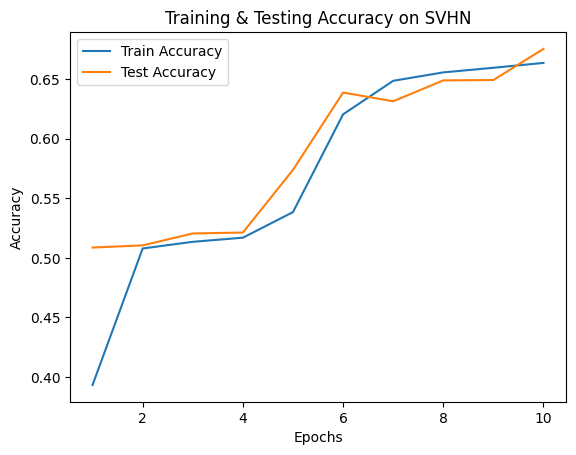

In [8]:
# Plot Akurasi
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Testing Accuracy on SVHN')
plt.show()